# Mini-Competition: One-Day Start to Finish Data Science Project

## The Task:
The task is to complete a full, start-to-finish data science project in one(ish) day, using the "best practice" skills we've learned over the past day of the course. 

## The Data:
The data shows real property information, including most recent sales price as of July 2018, for properties located Washington, D.C. The goal is to predict housing prices in DC. It is from [Kaggle](https://www.kaggle.com/christophercorrea/dc-residential-properties/version/7).

### Step 1: Exploration
- Explore the data and verify it, using tests of course! 
- At least 1 visualization of the data

### Step 2: Model Selection
- MUST use gridsearchCV in a pipeline!!

### Step 3: Production
- Once you've selected your desired model, put it (and the necessary feature engineering) in a pipeline. 
- Add at least 2 tests, including one for your final output!
- Bonus points if your predictor runs as its own python program from command line (rather than in a notebook).

Metric used to judge will be MAE (mean absolute error).
The team with the lowest MAE on the holdout test set at the end of Wednesday wins!

In [1]:
# imports 
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import pytest
import ipytest.magics
from jupyterthemes import jtplot
jtplot.style('chesterish')

__file__ = 'Mini Competition with Pipelines.ipynb' # set the file name (required)

In [67]:
#df = pd.read_csv('data/DC_properties_training.csv', index_col=0, low_memory=False)
df = pd.read_csv('data/holdout_test_data.csv', index_col=0, low_memory=False)
df_with_price = df[pd.notnull(df['PRICE'])].reset_index(drop=True)

# these are the columns we want to drop because they don't add value
df_with_price.drop(columns=['BLDG_NUM','STYLE','GIS_LAST_MOD_DTTM','SOURCE','FULLADDRESS','CITY','STATE','ZIPCODE',
'NATIONALGRID','ASSESSMENT_NBHD','ASSESSMENT_SUBNBHD','CENSUS_TRACT','CENSUS_BLOCK','WARD','SQUARE','X','Y','QUADRANT','GBA'], axis=1, inplace= True)

df_with_price = df_with_price[pd.notnull(df_with_price['AYB'])]

target = df_with_price['PRICE']
features = df_with_price.drop('PRICE',axis=1)

In [68]:
numeric_cols = features.select_dtypes(include=["int64","float64"])
nonnumeric_cols = features.select_dtypes(include=["object"])

In [ ]:
%%run_pytest
# ensure that target has no null values
assert target.isnull().values.any() == False

# ensure target and features are of same length
assert len(target) == features.shape[0]

In [ ]:
# investigate price
print(target.shape)
print(target.dtype)
print('Mean price of all houses: '+str(round(target.mean(),0)))

In [69]:
fq=df_with_price['PRICE'].describe()['25%']
thq=df_with_price['PRICE'].describe()['75%']
intq=fq-thq
df_with_price = df_with_price[(df_with_price['PRICE'] < (fq - 3 * intq)) &
(df_with_price['PRICE'] >(thq + 3 * intq))]

Text(0.5,0,'N Bedrooms')

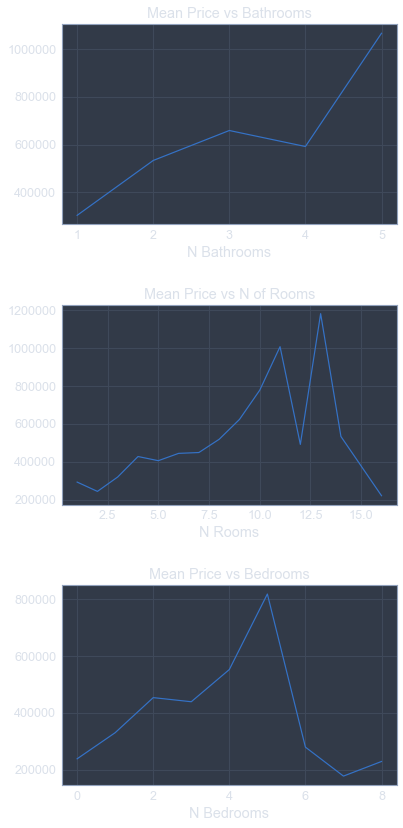

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(14)
fig.set_figwidth(6)
plt.subplots_adjust(hspace=0.4)

price_bathroom = df_with_price.groupby('BATHRM').PRICE.agg('mean')
ax1.plot(price_bathroom)
ax1.set_title('Mean Price vs Bathrooms')
ax1.set_xlabel('N Bathrooms')

price_rooms = df_with_price.groupby('ROOMS').PRICE.agg('mean')
ax2.plot(price_rooms)
ax2.set_title('Mean Price vs N of Rooms')
ax2.set_xlabel('N Rooms')

price_bedrooms = df_with_price.groupby('BEDRM').PRICE.agg('mean')
ax3.plot(price_bedrooms)
ax3.set_title('Mean Price vs Bedrooms')
ax3.set_xlabel('N Bedrooms')

In [6]:
lengths = []
for i in to_encode:
    x = len(df_with_price[i].value_counts())
    lengths.append(x)

print(lengths)
print(sum(lengths))

NameError: name 'to_encode' is not defined

In [46]:
saledate=pd.to_datetime(df_with_price['SALEDATE']).reset_index(drop=True)
saledate.dtype

dtype('<M8[ns]')

# Estimators & Transformers

In [71]:
# we begin by importing the parent estimators and transformers we want to inherit from, and other relevant pipeline classes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer, StandardScaler
from category_encoders.one_hot import OneHotEncoder


In [72]:
class ColumnSelector(BaseEstimator,TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        
    def fit(self,x,y=None):
        return self
    
    def transform(self,x,y=None):
        return x.loc[:,self.columns]

# Column Selection

In [73]:
# find discrete and scaled numeric columns
lengths = []
for i in numeric_cols.columns:
    x = len(numeric_cols[i].value_counts())
    lengths.append(x)

columns = np.asarray(numeric_cols.columns)
lengths = np.asarray(lengths)

numeric_col_lengths = np.column_stack((columns,lengths))

numeric_scaled = numeric_col_lengths[numeric_col_lengths[:,1] >= 250]
numeric_discrete = numeric_col_lengths[numeric_col_lengths[:,1] < 250]

print(numeric_scaled)
print()
print(numeric_discrete)

[['index' 912]
 ['LANDAREA' 745]
 ['CMPLX_NUM' 279]
 ['LIVING_GBA' 308]
 ['LATITUDE' 777]
 ['LONGITUDE' 778]]

[['BATHRM' 6]
 ['HF_BATHRM' 4]
 ['NUM_UNITS' 5]
 ['ROOMS' 17]
 ['BEDRM' 9]
 ['AYB' 122]
 ['YR_RMDL' 55]
 ['EYB' 111]
 ['STORIES' 12]
 ['SALE_NUM' 9]
 ['KITCHENS' 4]
 ['FIREPLACES' 6]
 ['USECODE' 8]]



# NAN Filling

In [74]:
# these are all our columns
all_columns = list(features.columns)


# fill the nans of scaled columns with mean 
'''CMPLX_NUM - fill with the mean (39954)
LIVING_GBA - fill with the mean (39954)
'''
features['CMPLX_NUM'].fillna(round(features['CMPLX_NUM'].mean(),4),inplace=True)
features['LIVING_GBA'].fillna(round(features['LIVING_GBA'].mean(),4),inplace=True)

# fill nans of discrete columns
'''
NUM_UNITs - remove, bad correlation (39954)
AYB - drop these rows (110)
YR_RMDL - make this median year (40175)
STORIES - remove, bad correlation (39,987)
KITCHENS - remove, bad correlation (39,995)
'''
features['YR_RMDL'].fillna(round(features['YR_RMDL'].median(),4),inplace=True)


# drop reminaing one-hot-encoded nan columns
features.drop(columns=['STRUCT',
'GRADE',
'CNDTN',
'EXTWALL',
'ROOF',
'INTWALL'], axis=1, inplace= True)

# drop remaining discrete nan colums
features.drop(columns=['STORIES','KITCHENS','NUM_UNITS'],axis=1,inplace=True)

# drop saledate columns
features.drop(columns=['SALEDATE'],axis=1,inplace=True)


In [75]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 913
Data columns (total 19 columns):
index         912 non-null int64
BATHRM        912 non-null int64
HF_BATHRM     912 non-null int64
HEAT          912 non-null object
AC            912 non-null object
ROOMS         912 non-null int64
BEDRM         912 non-null int64
AYB           912 non-null float64
YR_RMDL       912 non-null float64
EYB           912 non-null int64
QUALIFIED     912 non-null object
SALE_NUM      912 non-null int64
FIREPLACES    912 non-null int64
USECODE       912 non-null int64
LANDAREA      912 non-null int64
CMPLX_NUM     912 non-null float64
LIVING_GBA    912 non-null float64
LATITUDE      912 non-null float64
LONGITUDE     912 non-null float64
dtypes: float64(6), int64(10), object(3)
memory usage: 142.5+ KB


In [76]:
# get our final scaled columns
numeric_scaled_columns = list(numeric_scaled[:,0])

# get our final discrete columns
numeric_discrete_columns = list(numeric_discrete[:,0])
to_remove = ['STORIES','KITCHENS','NUM_UNITS']
x = pd.DataFrame(columns=numeric_discrete_columns)
numeric_discrete_columns = list(x.columns.difference(to_remove))

# get our final one-hot encoded columns
one_hot_encode_columns = ['HEAT',
                  'AC',
                  'QUALIFIED',
                  #'STRUCT',
                  #'GRADE',
                  #'CNDTN',
                  #'EXTWALL',
                  #'ROOF',
                  #'INTWALL'
                         ]
# drop all these for now
'''
STRUCT - 39954
GRADE - 39954
CNDTN - 39954
EXTWALL - 39954
ROOF - 39954
INTWALL - 39954
'''

# work out what to do with saledate
#to_encode = ['SALEDATE']

'\nSTRUCT - 39954\nGRADE - 39954\nCNDTN - 39954\nEXTWALL - 39954\nROOF - 39954\nINTWALL - 39954\n'

In [77]:
features[numeric_discrete_columns].dtypes


AYB           float64
BATHRM          int64
BEDRM           int64
EYB             int64
FIREPLACES      int64
HF_BATHRM       int64
ROOMS           int64
SALE_NUM        int64
USECODE         int64
YR_RMDL       float64
dtype: object

In [78]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 913
Data columns (total 19 columns):
index         912 non-null int64
BATHRM        912 non-null int64
HF_BATHRM     912 non-null int64
HEAT          912 non-null object
AC            912 non-null object
ROOMS         912 non-null int64
BEDRM         912 non-null int64
AYB           912 non-null float64
YR_RMDL       912 non-null float64
EYB           912 non-null int64
QUALIFIED     912 non-null object
SALE_NUM      912 non-null int64
FIREPLACES    912 non-null int64
USECODE       912 non-null int64
LANDAREA      912 non-null int64
CMPLX_NUM     912 non-null float64
LIVING_GBA    912 non-null float64
LATITUDE      912 non-null float64
LONGITUDE     912 non-null float64
dtypes: float64(6), int64(10), object(3)
memory usage: 142.5+ KB


In [55]:
nulls = []
for i in numeric_scaled_columns:
    x = features[numeric_scaled_columns][i].isnull().value_counts()
    nulls.append(x)
    
nulls

[False    97192
 Name: LANDAREA, dtype: int64, False    97192
 Name: CMPLX_NUM, dtype: int64, False    97192
 Name: LIVING_GBA, dtype: int64, False    97192
 Name: LATITUDE, dtype: int64, False    97192
 Name: LONGITUDE, dtype: int64]

In [56]:
print(features[numeric_scaled_columns])

'''
LANDAREA - no NANs (0)
CMPLX_NUM - fill with the mean (39954)
LIVING_GBA - fill with the mean (39954)
'''

       LANDAREA  CMPLX_NUM  LIVING_GBA   LATITUDE  LONGITUDE
0          1680  2442.6538    882.3485  38.914680 -77.040832
1          1680  2442.6538    882.3485  38.914684 -77.040678
2          1680  2442.6538    882.3485  38.914683 -77.040629
3          2196  2442.6538    882.3485  38.914331 -77.039715
4          1627  2442.6538    882.3485  38.915408 -77.040129
5          1424  2442.6538    882.3485  38.915017 -77.039903
6          1815  2442.6538    882.3485  38.915038 -77.039716
7          1424  2442.6538    882.3485  38.915018 -77.039844
8          1424  2442.6538    882.3485  38.915019 -77.040138
9          2090  2442.6538    882.3485  38.911370 -77.033774
10         2090  2442.6538    882.3485  38.911368 -77.033925
11         2090  2442.6538    882.3485  38.911368 -77.033972
12         2090  2442.6538    882.3485  38.911319 -77.034070
13         2090  2442.6538    882.3485  38.911337 -77.034156
14         1853  2442.6538    882.3485  38.911732 -77.034182
15         1853  2442.65

'\nLANDAREA - no NANs (0)\nCMPLX_NUM - fill with the mean (39954)\nLIVING_GBA - fill with the mean (39954)\n'

In [57]:
nulls = []
for i in numeric_discrete_columns:
    x = features[numeric_discrete_columns][i].isnull().value_counts()
    nulls.append(x)
    
nulls

[False    97192
 Name: AYB, dtype: int64, False    97192
 Name: BATHRM, dtype: int64, False    97192
 Name: BEDRM, dtype: int64, False    97192
 Name: EYB, dtype: int64, False    97192
 Name: FIREPLACES, dtype: int64, False    97192
 Name: HF_BATHRM, dtype: int64, False    97192
 Name: ROOMS, dtype: int64, False    97192
 Name: SALE_NUM, dtype: int64, False    97192
 Name: USECODE, dtype: int64, False    97192
 Name: YR_RMDL, dtype: int64]

In [58]:
nulls = []
for i in one_hot_encode_columns:
    x = features[one_hot_encode_columns][i].isnull().value_counts()
    nulls.append(x)
    
nulls

[False    97192
 Name: HEAT, dtype: int64, False    97192
 Name: AC, dtype: int64, False    97192
 Name: QUALIFIED, dtype: int64]

In [59]:
print(features[one_hot_encode_columns])

# drop all these for now
'''
STRUCT - 39954
GRADE - 39954
CNDTN - 39954
EXTWALL - 39954
ROOF - 39954
INTWALL - 39954
'''

                HEAT AC QUALIFIED
0          Warm Cool  Y         Q
1      Hot Water Rad  Y         Q
2      Hot Water Rad  Y         Q
3      Hot Water Rad  Y         Q
4      Hot Water Rad  Y         Q
5          Warm Cool  Y         Q
6          Warm Cool  Y         Q
7          Warm Cool  Y         Q
8      Hot Water Rad  Y         Q
9      Hot Water Rad  Y         U
10        Forced Air  Y         Q
11        Forced Air  Y         Q
12     Hot Water Rad  Y         Q
13     Hot Water Rad  N         U
14     Hot Water Rad  Y         Q
15        Forced Air  Y         Q
16        Forced Air  Y         Q
17         Warm Cool  Y         U
18        Forced Air  Y         Q
19         Warm Cool  Y         Q
20        Forced Air  Y         Q
21        Forced Air  Y         Q
22        Forced Air  Y         Q
23        Forced Air  Y         U
24         Warm Cool  Y         Q
25        Forced Air  N         U
26        Forced Air  Y         Q
27        Forced Air  Y         Q
28        Forc

'\nSTRUCT - 39954\nGRADE - 39954\nCNDTN - 39954\nEXTWALL - 39954\nROOF - 39954\nINTWALL - 39954\n'

# PIPELINES

In [60]:
from sklearn.pipeline import make_pipeline, make_union

# make_pipeline() is the function to use to put our transformer objects together
processing_pipeline = make_pipeline(
    # If using make_union, then we HAVE to first select all the columns we will pull from
    ColumnSelector(all_columns),
    make_union(
        # Select and don't do any further work to the discrete columns (they're already in the format we want)
        make_pipeline(ColumnSelector(numeric_discrete_columns),
        ),
        # Select numeric scalable columns, and scale using standardscaler transformer
        make_pipeline(
            ColumnSelector(numeric_scaled_columns),
            StandardScaler()
        ),
        
        # Select one-hot-encoding columns and encode them accordingly
        make_pipeline(
            ColumnSelector(one_hot_encode_columns),
            OneHotEncoder()
        )
    )
)


In [61]:
# we can now call fit_transfrom on the processing_pipeline we made to link the together and prep the data
processed = processing_pipeline.fit_transform(features)

Mini Competition with Pipelines.ipynb:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  "# Mini-Competition: One-Day Start to Finish Data Science Project\n",
/Users/garethjones/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [18]:
features.dtypes

BATHRM          int64
HF_BATHRM       int64
HEAT           object
AC             object
ROOMS           int64
BEDRM           int64
AYB           float64
YR_RMDL       float64
EYB             int64
QUALIFIED      object
SALE_NUM        int64
FIREPLACES      int64
USECODE         int64
LANDAREA        int64
CMPLX_NUM     float64
LIVING_GBA    float64
LATITUDE      float64
LONGITUDE     float64
dtype: object

In [19]:
features.isnull().any()

BATHRM        False
HF_BATHRM     False
HEAT          False
AC            False
ROOMS         False
BEDRM         False
AYB           False
YR_RMDL       False
EYB           False
QUALIFIED     False
SALE_NUM      False
FIREPLACES    False
USECODE       False
LANDAREA      False
CMPLX_NUM     False
LIVING_GBA    False
LATITUDE      False
LONGITUDE     False
dtype: bool

In [20]:
features.select_dtypes('float64').round(4)

,AYB,YR_RMDL,CMPLX_NUM,LIVING_GBA,LATITUDE,LONGITUDE
0,1910.0,1988.0,2442.6538,882.3485,38.9147,-77.0408
1,1910.0,2009.0,2442.6538,882.3485,38.9147,-77.0407
2,1900.0,2003.0,2442.6538,882.3485,38.9147,-77.0406
3,1913.0,2005.0,2442.6538,882.3485,38.9143,-77.0397
4,1906.0,2011.0,2442.6538,882.3485,38.9154,-77.0401
5,1908.0,2008.0,2442.6538,882.3485,38.9150,-77.0399
6,1917.0,2000.0,2442.6538,882.3485,38.9150,-77.0397
7,1908.0,2006.0,2442.6538,882.3485,38.9150,-77.0398
8,1908.0,2013.0,2442.6538,882.3485,38.9150,-77.0401
9,1880.0,2009.0,2442.6538,882.3485,38.9114,-77.0338


In [ ]:
%%run_pytest[clean]

def test_processingpipeline():
    # remember, this first pipeline only acts on the features, not the target.
    processed = processing_pipeline.fit_transform(features)
    
    # check for data leakage
    assert features.shape[0] == processed.shape[0]

In [21]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97192 entries, 0 to 97301
Data columns (total 18 columns):
BATHRM        97192 non-null int64
HF_BATHRM     97192 non-null int64
HEAT          97192 non-null object
AC            97192 non-null object
ROOMS         97192 non-null int64
BEDRM         97192 non-null int64
AYB           97192 non-null float64
YR_RMDL       97192 non-null float64
EYB           97192 non-null int64
QUALIFIED     97192 non-null object
SALE_NUM      97192 non-null int64
FIREPLACES    97192 non-null int64
USECODE       97192 non-null int64
LANDAREA      97192 non-null int64
CMPLX_NUM     97192 non-null float64
LIVING_GBA    97192 non-null float64
LATITUDE      97192 non-null float64
LONGITUDE     97192 non-null float64
dtypes: float64(6), int64(9), object(3)
memory usage: 14.1+ MB


In [62]:
# split data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

In [63]:
from sklearn.ensemble import RandomForestRegressor

# we're going to add a random forest regressor to estimate the data in our pipeline so far
finalpipeline = (make_pipeline(processing_pipeline, RandomForestRegressor(random_state=1, 
                                                                          n_jobs=-1, 
                                                                          n_estimators=100)))

# then we can go ahead and fit this pipline on our training data, and it will do the random forest predictions for us
finalpipeline.fit(x_train, y_train)

Mini Competition with Pipelines.ipynb:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  "# Mini-Competition: One-Day Start to Finish Data Science Project\n",
/Users/garethjones/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'QUALIFIED', 'SALE_NUM', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KIT...stimators=300, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [24]:
# create a function that will predict on our pipeline and put them together in a dataframe

def compare_predictions(x, y, finalpipeline, mean_target_value):
    # generate predictions:
    # Note: finalpipeline must have already been fit.
    
    predictions = finalpipeline.predict(x)
    y = y.reset_index()
    y.drop('index', axis=1, inplace=True)
    
    # a "lazy prediction" is where we return the average value of the target for every prediction
    # this just creates a vector of the same shape as predictions, filled with the mean absenteeism
    lazy_predictions = np.full(predictions.shape, mean_target_value)
    
    # put target, randomforest predictions, and mean absenteeism into one dataframe
    final_predictions = pd.DataFrame(pd.concat([y, pd.Series(predictions), pd.Series(lazy_predictions)], axis=1))
    final_predictions.rename(columns={'PRICE': 'True values',
                                      0: 'Predicted values',
                                      1: 'Lazy Predicted values'}, inplace=True)
    
    # use sklearn metrics to compute the rmse, mae, and r2 errors of our predictions against target
    rmse_lazy = sqrt(mean_squared_error(y, lazy_predictions))
    mae_lazy = mean_absolute_error(y, lazy_predictions)
    r2_lazy = r2_score(y, lazy_predictions)
    
    rmse = sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    # print the values
    print('RMSE Lazy Predictor', rmse_lazy)
    print('MAE Lazy Predictor', mae_lazy)
    print('R^2 Lazy Predictor', r2_lazy)
    print()
    print('RMSE', rmse)
    print('MAE', mae)
    print('R^2', r2)
    print()
    print('RMSE Improvement:', rmse_lazy - rmse)
    print('MAE Inprovement:', mae_lazy - mae)
    print('R^2 Improvement:', abs(r2_lazy - r2))
    
    #plot a figure of the predictions for each line in our dataset
    plt.figure(figsize=(20,10))

    plt.plot(final_predictions.index, final_predictions['True values'], c='red', label='True Values')
    # plot a second data series 'Short students' in blue using the last three elements of x and y 
    plt.plot(final_predictions.index, final_predictions['Predicted values'], c='blue', label='Predicted Values')
    plt.plot(final_predictions.index, final_predictions['Lazy Predicted values'], c='black', label='Lazy Predicted Values')
    plt.legend(loc='best')
    plt.show()
    return predictions

In [64]:
mean_target_value = target.mean()

Mini Competition with Pipelines.ipynb:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  "# Mini-Competition: One-Day Start to Finish Data Science Project\n",
/Users/garethjones/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


RMSE Lazy Predictor 6843581.175444291
MAE Lazy Predictor 925884.9268033445
R^2 Lazy Predictor -8.726159854033355e-06

RMSE 1041185.4376092826
MAE 63847.511029947666
R^2 0.9768530851393107

RMSE Improvement: 5802395.737835009
MAE Inprovement: 862037.4157733968
R^2 Improvement: 0.9768618112991647


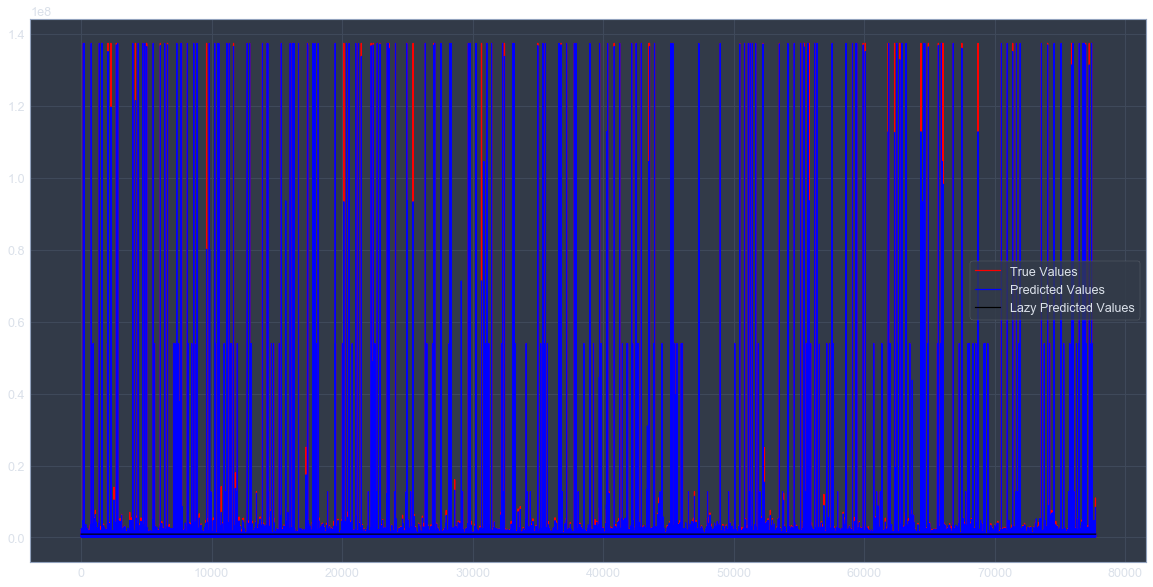

array([284437.87166667, 503207.1       ,  99339.68333333, ...,
       137125.75      , 351862.1565873 , 612456.66333333])

In [65]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

compare_predictions(x_train,y_train,finalpipeline,mean_target_value)

Mini Competition with Pipelines.ipynb:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  "# Mini-Competition: One-Day Start to Finish Data Science Project\n",
/Users/garethjones/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


RMSE Lazy Predictor 7765079.689050628
MAE Lazy Predictor 1022102.2639525997
R^2 Lazy Predictor -0.00010844959967837298

RMSE 681129.2399994321
MAE 127047.91797975167
R^2 0.9923048992339516

RMSE Improvement: 7083950.449051196
MAE Inprovement: 895054.345972848
R^2 Improvement: 0.99241334883363


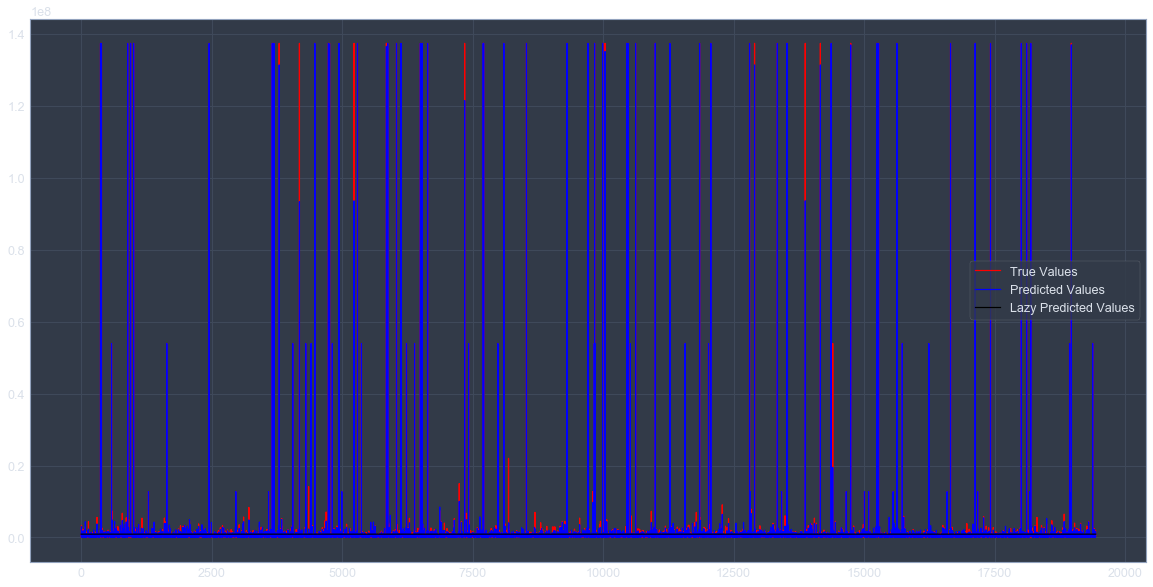

array([581523.35666667, 182716.30666667, 566173.54960317, ...,
       512057.11333333, 455263.95514671, 428229.84      ])

In [66]:
compare_predictions(x_test,y_test,finalpipeline,mean_target_value)

Mini Competition with Pipelines.ipynb:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  "# Mini-Competition: One-Day Start to Finish Data Science Project\n",
/Users/garethjones/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


RMSE Lazy Predictor 9569371.97330833
MAE Lazy Predictor 1339014.4843028649
R^2 Lazy Predictor -0.0017439125113489773

RMSE 3190022.2910987544
MAE 255078.71782886572
R^2 0.8886789549712993

RMSE Improvement: 6379349.682209576
MAE Inprovement: 1083935.7664739992
R^2 Improvement: 0.8904228674826483


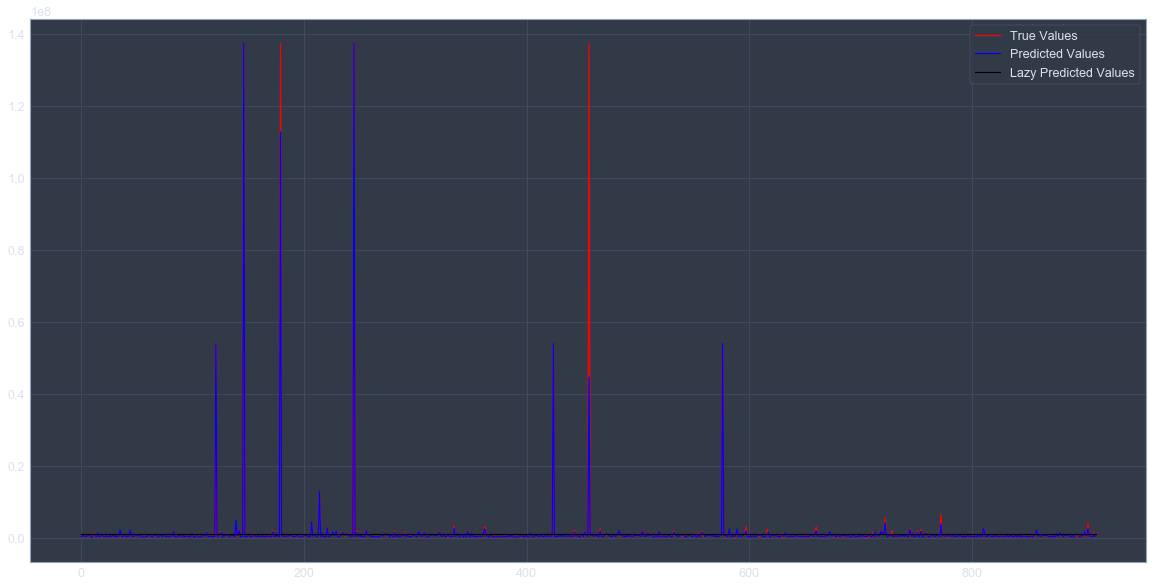

array([2.27807420e+05, 4.32933533e+05, 5.27609431e+05, 4.30728227e+05,
       2.68920413e+05, 4.27877134e+05, 4.17351727e+05, 7.37850220e+05,
       5.15110916e+05, 3.07545250e+05, 1.33898997e+05, 9.52027940e+05,
       8.01850023e+05, 2.97419310e+05, 1.96582552e+05, 1.34444136e+06,
       1.53571870e+05, 3.39115090e+05, 4.78413900e+05, 5.07257503e+05,
       3.20292031e+05, 1.49980337e+05, 4.49697512e+05, 4.87769213e+05,
       3.40696733e+05, 2.29272967e+05, 6.69439143e+05, 2.12908443e+05,
       5.32382250e+05, 7.65202517e+05, 1.95079467e+05, 4.72745873e+05,
       2.04630061e+05, 4.29103117e+05, 3.27568090e+05, 2.12982711e+06,
       2.97267403e+05, 1.23752393e+05, 3.21756767e+05, 4.60988829e+05,
       4.51987839e+05, 1.93559654e+05, 2.85004967e+05, 2.74893490e+05,
       2.00108192e+06, 1.31843866e+06, 1.76133426e+05, 3.44441390e+05,
       4.45827747e+05, 4.68552684e+05, 4.74475314e+05, 5.28492483e+05,
       4.77492032e+05, 5.59729500e+05, 2.53107889e+05, 4.84921133e+05,
      

In [79]:
compare_predictions(features,target,finalpipeline,mean_target_value)